<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/Final_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.2 MB/s eta 0:00:00


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
PSNR: 22.66 dB   SSIM: 0.6047


<Figure size 1200x400 with 0 Axes>

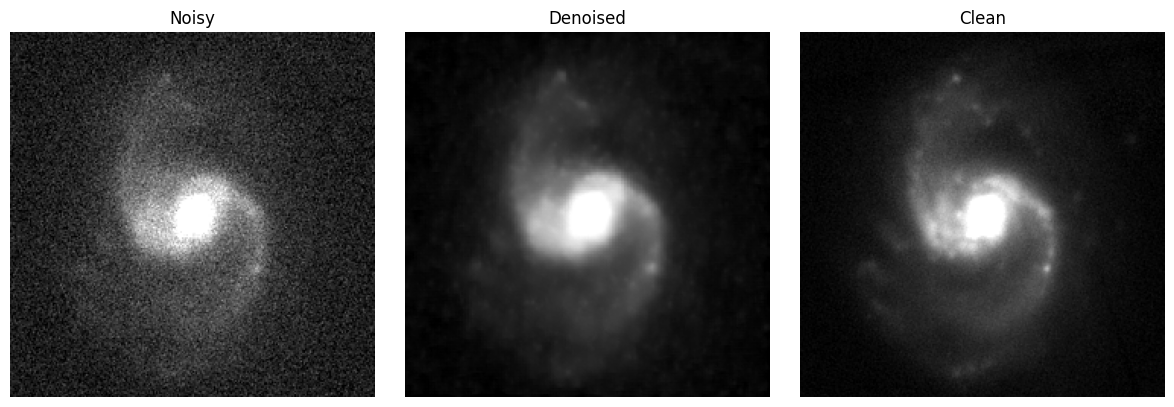

Flux err: 15.03%
HLR  err: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Over 14 stamps:
 • Mean flux error = 15.76% ± 8.57%
 • Mean HLR  error = 3.01% ± 6.30%


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from photutils.aperture import CircularAperture, aperture_photometry
from glob import glob

# ── 1. File paths & dirs ─────────────────────────────────────────────────────
clean_fits_path      = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_fits_path      = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
autoencoder_model    = "/content/drive/MyDrive/PS1_Models/unet_with_atten_v01.h5"
clean_dir            = "/content/drive/MyDrive/PS1_Dataset/renamed/clean"
noisy_dir            = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy"

# ── 2. Custom layers ───────────────────────────────────────────────────────────
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.query = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.key   = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.value = tf.keras.layers.Conv2D(channels,    1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    def call(self, x):
        q = self.query(x); k = self.key(x); v = self.value(x)
        # (b,h,w,c)->(b,hw,hw) attention map
        scores = self.softmax(tf.matmul(q, k, transpose_b=True))
        ctx    = tf.matmul(scores, v)
        return tf.reshape(ctx, tf.shape(x))

class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.channels  = channels
        self.num_heads = num_heads
        self.query = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.key   = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.value = tf.keras.layers.Conv2D(channels,    1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    def call(self, x):
        # split into heads
        q = tf.concat(tf.split(self.query(x), self.num_heads, -1), -1)
        k = tf.concat(tf.split(self.key(x),   self.num_heads, -1), -1)
        v = tf.concat(tf.split(self.value(x), self.num_heads, -1), -1)
        scores = self.softmax(tf.matmul(q, k, transpose_b=True))
        ctx    = tf.matmul(scores, v)
        # merge heads
        return tf.reshape(ctx, tf.shape(x))

# ── 3. Preprocessing ───────────────────────────────────────────────────────────
def preprocess_fits(path, target_size=(240,240)):
    arr = fits.getdata(path).astype(np.float32)
    arr = np.nan_to_num(arr)
    p1, p99 = np.percentile(arr, (1,99))
    arr = np.clip(arr, p1, p99)
    arr = (arr - p1)/(p99 - p1 + 1e-8)
    return tf.image.resize(arr[...,None], target_size).numpy().squeeze()

# ── 4. Load model ──────────────────────────────────────────────────────────────
model = load_model(
    autoencoder_model,
    custom_objects={
      'AttentionLayer': AttentionLayer,
      'MultiHeadAttentionLayer': MultiHeadAttentionLayer,
      'mse': losses.MeanSquaredError
    }
)

# ── 5. Single-stamp inference & PSNR/SSIM ──────────────────────────────────────
clean_img = preprocess_fits(clean_fits_path)
noisy_img = preprocess_fits(noisy_fits_path)
denoised  = model.predict(noisy_img[None,...,None])[0,...,0]

psnr_val = peak_signal_noise_ratio(clean_img, denoised, data_range=1.0)
ssim_val = structural_similarity(clean_img, denoised, data_range=1.0)
print(f"PSNR: {psnr_val:.2f} dB   SSIM: {ssim_val:.4f}")

# visualize
plt.figure(figsize=(12,4))
for ax, img, title in zip(plt.subplots(1,3,figsize=(12,4))[1],
                          [noisy_img, denoised, clean_img],
                          ["Noisy","Denoised","Clean"]):
    ax.imshow(img, cmap='gray', vmin=np.percentile(img,1), vmax=np.percentile(img,99))
    ax.set_title(title); ax.axis('off')
plt.tight_layout()
plt.show()

# ── 6. Flux & HLR metrics ──────────────────────────────────────────────────────
def compute_flux(im, center, r):
    ap = CircularAperture([center], r=r)
    return aperture_photometry(im, ap)['aperture_sum'][0]

def compute_hlr(im, center, max_r, steps=100):
    total = compute_flux(im, center, max_r)
    half  = total / 2.0
    # start at max_r/steps rather than 0
    radii = np.linspace(max_r/steps, max_r, steps)
    for r in radii:
        if compute_flux(im, center, r) >= half:
            return r
    return max_r


FWHM       = 3.0
APER_RAD   = 3*FWHM
CEN        = (clean_img.shape[1]/2, clean_img.shape[0]/2)

flux_c = compute_flux(clean_img, CEN, APER_RAD)
flux_d = compute_flux(denoised,  CEN, APER_RAD)
hlr_c  = compute_hlr(clean_img,  CEN, APER_RAD)
hlr_d  = compute_hlr(denoised,   CEN, APER_RAD)

print(f"Flux err: {100*abs(flux_d-flux_c)/flux_c:.2f}%")
print(f"HLR  err: {100*abs(hlr_d -hlr_c )/hlr_c:.2f}%")

# ── 7. Loop over full directory ────────────────────────────────────────────────
all_flux_errs, all_hlr_errs = [], []
for cp, np_ in zip(sorted(glob(clean_dir+"/*.fits")), sorted(glob(noisy_dir+"/*.fits"))):
    c = preprocess_fits(cp)
    n = preprocess_fits(np_)
    d = model.predict(n[None,...,None])[0,...,0]

    fc = compute_flux(c, CEN, APER_RAD)
    fd = compute_flux(d, CEN, APER_RAD)
    all_flux_errs.append(100*abs(fd-fc)/fc)

    hc = compute_hlr(c, CEN, APER_RAD)
    hd = compute_hlr(d, CEN, APER_RAD)
    all_hlr_errs.append(100*abs(hd-hc)/hc)

print(f"\nOver {len(all_flux_errs)} stamps:")
print(f" • Mean flux error = {np.mean(all_flux_errs):.2f}% ± {np.std(all_flux_errs):.2f}%")
print(f" • Mean HLR  error = {np.mean(all_hlr_errs):.2f}% ± {np.std(all_hlr_errs):.2f}%")


##On whole dataset

In [ ]:
import os
import re
import numpy as np
import tensorflow as tf
from astropy.io import fits
from glob import glob
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from photutils.aperture import CircularAperture, aperture_photometry

# ── 0. YOUR PATHS ─────────────────────────────────────────────────────────────
CLEAN_DIR = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/clean"
NOISY_DIR = "/content/drive/MyDrive/sdss_image_dataset/augment_set3/noisy"
MODEL_PATH = "/content/drive/MyDrive/PS1_Models/unet_with_atten_v01.h5"

# ── 1. CUSTOM LAYERS ───────────────────────────────────────────────────────────
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.query = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.key   = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.value = tf.keras.layers.Conv2D(channels,    1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    def call(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        scores = tf.matmul(q, k, transpose_b=True)
        attn   = self.softmax(scores)
        ctx    = tf.matmul(attn, v)
        return tf.reshape(ctx, tf.shape(x))

class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.query = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.key   = tf.keras.layers.Conv2D(channels//8, 1, padding="same")
        self.value = tf.keras.layers.Conv2D(channels,    1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    def call(self, x):
        q = tf.concat(tf.split(self.query(x), self.num_heads, -1), -1)
        k = tf.concat(tf.split(self.key(x),   self.num_heads, -1), -1)
        v = tf.concat(tf.split(self.value(x), self.num_heads, -1), -1)
        scores = tf.matmul(q, k, transpose_b=True)
        attn   = self.softmax(scores)
        ctx    = tf.matmul(attn, v)
        return tf.reshape(ctx, tf.shape(x))

# ── 2. FITS PREPROCESSING ──────────────────────────────────────────────────────
def preprocess_fits(path, size=(240,240)):
    data = fits.getdata(path, memmap=False).astype(np.float32)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(data, (1,99))
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1 + 1e-8)
    resized = tf.image.resize(data[...,None], size).numpy().squeeze()
    return resized

# ── 3. FLUX & HLR METRICS ──────────────────────────────────────────────────────
def compute_flux(img, center, r):
    aper = CircularAperture([center], r=r)
    return aperture_photometry(img, aper)['aperture_sum'][0]

def compute_hlr(img, center, max_r, steps=100):
    total = compute_flux(img, center, max_r)
    half  = total / 2.0
    radii = np.linspace(max_r/steps, max_r, steps)
    for rad in radii:
        if compute_flux(img, center, rad) >= half:
            return rad
    return max_r

# ── 4. LOAD YOUR TRAINED MODEL ─────────────────────────────────────────────────
model = load_model(
    MODEL_PATH,
    custom_objects={
        "AttentionLayer": AttentionLayer,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
        "mse": losses.MeanSquaredError
    }
)

# ── 5. PAIRING CLEAN & NOISY ───────────────────────────────────────────────────
clean_files = glob(os.path.join(CLEAN_DIR, "*.fits"))
noisy_files = glob(os.path.join(NOISY_DIR, "*.fits"))

def canonical_key(path):
    """Normalize frame-r- vs frame-u-, strip extension."""
    name = os.path.basename(path)
    # turn both frame-r-... and frame-u-... into frame-...
    key = re.sub(r'^frame-[ru]-', 'frame-', name)
    return key.rsplit('.',1)[0]

clean_map = { canonical_key(p): p for p in clean_files }
noisy_map = { canonical_key(p): p for p in noisy_files }

common_keys = sorted(set(clean_map) & set(noisy_map))
if not common_keys:
    raise RuntimeError("❌ No matching FITS stamps found — check your r↔u naming")

# ── 6. EVALUATION LOOP ─────────────────────────────────────────────────────────
psnrs, ssims, flux_errs, hlr_errs = [], [], [], []
FWHM    = 3.0
APER_R  = 3 * FWHM

for key in common_keys:
    c_path = clean_map[key]
    n_path = noisy_map[key]

    clean_img = preprocess_fits(c_path)
    noisy_img = preprocess_fits(n_path)
    # model expects shape (1,H,W,1)
    denoised = model.predict(noisy_img[None,...,None], verbose=0)[0,...,0]

    # PSNR & SSIM
    psnrs.append( peak_signal_noise_ratio(clean_img, denoised, data_range=1.0) )
    ssims.append( structural_similarity(clean_img, denoised, data_range=1.0) )

    # flux & hlr error
    H, W = clean_img.shape
    center = (W/2, H/2)
    f_c = compute_flux(clean_img, center, APER_R)
    f_d = compute_flux(denoised,   center, APER_R)
    flux_errs.append(100 * abs(f_d - f_c) / f_c)
    hlr_c = compute_hlr(clean_img, center, APER_R)
    hlr_d = compute_hlr(denoised,   center, APER_R)
    hlr_errs.append(100 * abs(hlr_d - hlr_c) / hlr_c)

# ── 7. REPORT ─────────────────────────────────────────────────────────────────
print(f"📊 Evaluated {len(common_keys)} stamps")
print(f" • PSNR:     {np.mean(psnrs):.2f} ± {np.std(psnrs):.2f} dB")
print(f" • SSIM:     {np.mean(ssims):.3f} ± {np.std(ssims):.3f}")
print(f" • Flux err: {np.mean(flux_errs):.1f}% ± {np.std(flux_errs):.1f}%")
print(f" • HLR err:  {np.mean(hlr_errs):.1f}% ± {np.std(hlr_errs):.1f}%")


📊 Evaluated 3147 stamps
 • PSNR:     16.94 ± 0.98 dB
 • SSIM:     0.070 ± 0.029
 • Flux err: 12.9% ± 28.1%
 • HLR err:  0.9% ± 1.1%


#-------------------------

Epoch 1/50


215/215 - 32s - 148ms/step - loss: 0.0191 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 2/50
215/215 - 5s - 25ms/step - loss: 0.0191 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 3/50


215/215 - 6s - 27ms/step - loss: 0.0190 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 4/50
215/215 - 5s - 25ms/step - loss: 0.0190 - val_loss: 0.0115 - learning_rate: 1.0000e-04
Epoch 5/50


215/215 - 6s - 27ms/step - loss: 0.0190 - val_loss: 0.0112 - learning_rate: 1.0000e-04
Epoch 6/50


215/215 - 6s - 28ms/step - loss: 0.0188 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 7/50


215/215 - 6s - 28ms/step - loss: 0.0187 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 8/50


215/215 - 6s - 28ms/step - loss: 0.0181 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 9/50


215/215 - 6s - 28ms/step - loss: 0.0178 - val_loss: 0.0101 - learning_rate: 1.0000e-04
Epoch 10/50


215/215 - 6s - 28ms/step - loss: 0.0176 - val_loss: 0.0099 - learning_rate: 1.0000e-04
Epoch 11/50
215/215 - 5s - 25ms/step - loss: 0.0176 - val_loss: 0.0101 - learning_rate: 1.0000e-04
Epoch 12/50
215/215 - 5s - 25ms/step - loss: 0.0173 - val_loss: 0.0099 - learning_rate: 1.0000e-04
Epoch 13/50
215/215 - 5s - 25ms/step - loss: 0.0172 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 14/50


215/215 - 6s - 27ms/step - loss: 0.0170 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 15/50


215/215 - 6s - 28ms/step - loss: 0.0172 - val_loss: 0.0096 - learning_rate: 1.0000e-04
Epoch 16/50
215/215 - 5s - 24ms/step - loss: 0.0173 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 17/50
215/215 - 5s - 25ms/step - loss: 0.0170 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 18/50


215/215 - 6s - 28ms/step - loss: 0.0169 - val_loss: 0.0096 - learning_rate: 1.0000e-04
Epoch 19/50


215/215 - 6s - 28ms/step - loss: 0.0171 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 20/50
215/215 - 5s - 25ms/step - loss: 0.0170 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 21/50


215/215 - 6s - 27ms/step - loss: 0.0165 - val_loss: 0.0094 - learning_rate: 1.0000e-05
Epoch 22/50
215/215 - 5s - 25ms/step - loss: 0.0164 - val_loss: 0.0096 - learning_rate: 1.0000e-05
Epoch 23/50


215/215 - 6s - 27ms/step - loss: 0.0164 - val_loss: 0.0092 - learning_rate: 1.0000e-05
Epoch 24/50


215/215 - 6s - 28ms/step - loss: 0.0164 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 25/50


215/215 - 6s - 27ms/step - loss: 0.0163 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 26/50


215/215 - 6s - 28ms/step - loss: 0.0163 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 27/50
215/215 - 5s - 25ms/step - loss: 0.0163 - val_loss: 0.0098 - learning_rate: 1.0000e-05
Epoch 28/50


215/215 - 6s - 27ms/step - loss: 0.0163 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 29/50
215/215 - 5s - 25ms/step - loss: 0.0163 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 30/50


215/215 - 6s - 28ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 31/50
215/215 - 5s - 25ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 32/50
215/215 - 5s - 25ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 33/50
215/215 - 5s - 24ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-05
Epoch 34/50


215/215 - 6s - 27ms/step - loss: 0.0162 - val_loss: 0.0090 - learning_rate: 1.0000e-06
Epoch 35/50
215/215 - 5s - 25ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-06
Epoch 36/50
215/215 - 5s - 25ms/step - loss: 0.0162 - val_loss: 0.0091 - learning_rate: 1.0000e-06
Epoch 37/50


215/215 - 6s - 28ms/step - loss: 0.0161 - val_loss: 0.0090 - learning_rate: 1.0000e-06
Epoch 38/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-06
Epoch 39/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-07
Epoch 40/50
215/215 - 5s - 24ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-07
Epoch 41/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-07
Epoch 42/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-07
Epoch 43/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-07
Epoch 44/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-08
Epoch 45/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-08
Epoch 46/50
215/215 - 5s - 25ms/step - loss: 0.0161 - val_loss: 0.0091 - learning_rate: 1.0000e-08
Epoch 47/50
215/215 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 - 18s - 83ms/step - loss: 0.0886 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 2/50
214/214 - 3s - 13ms/step - loss: 0.0187 - val_loss: 0.0180 - learning_rate: 1.0000e-04
Epoch 3/50
214/214 - 3s - 13ms/step - loss: 0.0173 - val_loss: 0.0172 - learning_rate: 1.0000e-04
Epoch 4/50
214/214 - 3s - 13ms/step - loss: 0.0167 - val_loss: 0.0165 - learning_rate: 1.0000e-04
Epoch 5/50
214/214 - 3s - 13ms/step - loss: 0.0164 - val_loss: 0.0162 - learning_rate: 1.0000e-04
Epoch 6/50
214/214 - 3s - 13ms/step - loss: 0.0156 - val_loss: 0.0154 - learning_rate: 1.0000e-04
Epoch 7/50
214/214 - 3s - 13ms/step - loss: 0.0148 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 8/50
214/214 - 3s - 13ms/step - loss: 0.0133 - val_loss: 0.0116 - learning_rate: 1.0000e-04
Epoch 9/50


214/214 - 3s - 16ms/step - loss: 0.0111 - val_loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 10/50


214/214 - 3s - 16ms/step - loss: 0.0087 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 11/50


214/214 - 3s - 16ms/step - loss: 0.0071 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 12/50


214/214 - 3s - 15ms/step - loss: 0.0062 - val_loss: 0.0051 - learning_rate: 1.0000e-04
Epoch 13/50


214/214 - 3s - 16ms/step - loss: 0.0056 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 14/50


214/214 - 3s - 16ms/step - loss: 0.0053 - val_loss: 0.0047 - learning_rate: 1.0000e-04
Epoch 15/50


214/214 - 3s - 15ms/step - loss: 0.0050 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 16/50
214/214 - 3s - 13ms/step - loss: 0.0048 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 17/50


214/214 - 3s - 16ms/step - loss: 0.0047 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 18/50


214/214 - 3s - 16ms/step - loss: 0.0046 - val_loss: 0.0043 - learning_rate: 1.0000e-04
Epoch 19/50


214/214 - 3s - 15ms/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 1.0000e-04
Epoch 20/50


214/214 - 3s - 16ms/step - loss: 0.0044 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 21/50


214/214 - 3s - 16ms/step - loss: 0.0043 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 22/50
214/214 - 3s - 13ms/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 23/50


214/214 - 3s - 15ms/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 24/50
214/214 - 3s - 13ms/step - loss: 0.0041 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 25/50


214/214 - 3s - 16ms/step - loss: 0.0040 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 26/50
214/214 - 3s - 13ms/step - loss: 0.0040 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 27/50


214/214 - 3s - 15ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 28/50


214/214 - 3s - 16ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 29/50


214/214 - 3s - 16ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 30/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 31/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 32/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-05
Epoch 33/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-06
Epoch 34/50


214/214 - 3s - 16ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-06
Epoch 35/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-06
Epoch 36/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-06
Epoch 37/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-06
Epoch 38/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-07
Epoch 39/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-07
Epoch 40/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-07
Epoch 41/50


214/214 - 3s - 16ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-07
Epoch 42/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-07
Epoch 43/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 44/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 45/50


214/214 - 3s - 16ms/step - loss: 0.0038 - val_loss: 0.0037 - learning_rate: 1.0000e-08
Epoch 46/50
214/214 - 3s - 13ms/step - loss: 0.0038 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 47/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 48/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 49/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-08
Epoch 50/50
214/214 - 3s - 13ms/step - loss: 0.0039 - val_loss: 0.0038 - learning_rate: 1.0000e-08


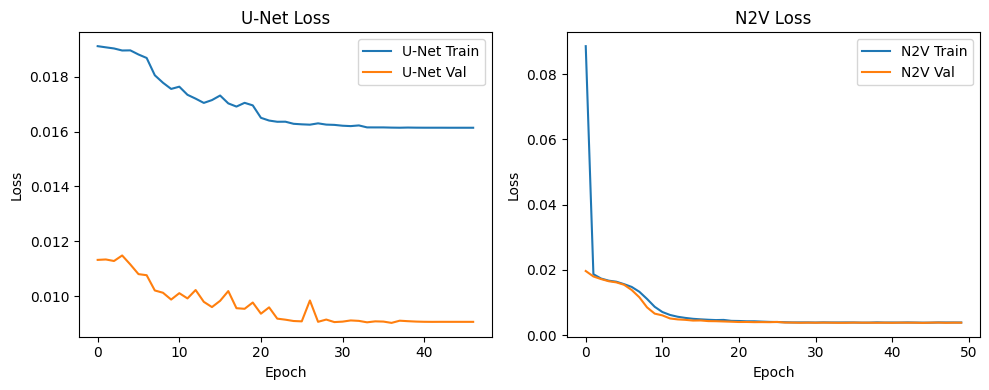

In [ ]:
# ─── train_and_save_and_plot.py in one cell ────────────────────────────────────
import os, numpy as np, tensorflow as tf
from glob import glob
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

# 1. CONFIG
TRAIN_NOISY = "/content/drive/MyDrive/SDSS_augmented_npy/train/noisy"
TRAIN_CLEAN = "/content/drive/MyDrive/SDSS_augmented_npy/train/clean"
VAL_NOISY   = "/content/drive/MyDrive/SDSS_augmented_npy/val/noisy"
VAL_CLEAN   = "/content/drive/MyDrive/SDSS_augmented_npy/val/clean"

# 2. Loss
def ssim_mse_loss(y_true, y_pred):
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse  = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.8*mse + 0.2*ssim

# 3. N2V Generator (128×128)
class N2VGen(Sequence):
    def __init__(self, imgs, bs=8, ps=128, mr=0.03):
        self.imgs, self.bs, self.ps, self.mr = imgs, bs, ps, mr
    def __len__(self): return len(self.imgs)//self.bs
    def __getitem__(self, idx):
        X = np.zeros((self.bs,self.ps,self.ps,1),np.float32)
        Y = np.zeros_like(X)
        i=0
        while i<self.bs:
            im = self.imgs[np.random.randint(len(self.imgs))]
            if im.ndim==2: im=im[...,None]
            h,w,_=im.shape
            if h<self.ps or w<self.ps: continue
            y0=np.random.randint(0,h-self.ps+1); x0=np.random.randint(0,w-self.ps+1)
            p = im[y0:y0+self.ps, x0:x0+self.ps]
            m = np.random.rand(*p.shape)<self.mr
            offsets = np.random.randint(-1,2,p.shape)
            pm = p.copy(); pm[m]=np.clip(p+offsets*m,0,1)[m]
            X[i]=pm; Y[i]=p; i+=1
        return X,Y

# 4. Build U-Net (shared code for both sizes)
def build_unet(shape, base=32, depth=4):
    inp=layers.Input(shape); x=inp; skips=[]
    for d in range(depth):
        x=layers.Conv2D(base*2**d,3,padding='same',activation='relu')(x)
        x=layers.Conv2D(base*2**d,3,padding='same',activation='relu')(x)
        skips.append(x)
        x=layers.MaxPool2D()(x)
    x=layers.Conv2D(base*2**depth,3,padding='same',activation='relu')(x)
    x=layers.Conv2D(base*2**depth,3,padding='same',activation='relu')(x)
    for d in reversed(range(depth)):
        x=layers.UpSampling2D()(x)
        x=layers.concatenate([x,skips[d]])
        x=layers.Conv2D(base*2**d,3,padding='same',activation='relu')(x)
        x=layers.Conv2D(base*2**d,3,padding='same',activation='relu')(x)
    return models.Model(inp, layers.Conv2D(1,1,padding='same',activation='sigmoid')(x))

# 5. Load .npy into lists
def load_list(dirn):
    return [np.load(f).astype(np.float32) for f in sorted(glob(os.path.join(dirn,"*.npy")))]

tno = load_list(TRAIN_NOISY); tcl = load_list(TRAIN_CLEAN)
vno = load_list(VAL_NOISY);   vcl = load_list(VAL_CLEAN)

# 6. Prep full‐image arrays (240×240,1)
def prep_full(imgs, size=(240,240)):
    out=[]
    for im in imgs:
        d=np.clip(im,0,1).astype(np.float32)
        if d.ndim==2: d=d[...,None]
        d=tf.image.resize(d,size).numpy()
        out.append(d)
    return np.stack(out,0)

Xtr=prep_full(tno);  Ytr=prep_full(tcl)
Xvl=prep_full(vno);  Yvl=prep_full(vcl)

# 7. Instantiate & compile
unet = build_unet((240,240,1))
unet.compile(optimizer=optimizers.Adam(1e-4), loss='mse')
n2v  = build_unet((128,128,1))
n2v.compile(optimizer=optimizers.Adam(1e-4), loss=ssim_mse_loss)

# 8. Generators & callbacks
tr_gen = N2VGen(tno)
vl_gen = N2VGen(vno)
cb = [
    ModelCheckpoint("unet_full_best.h5", save_best_only=True),
    ModelCheckpoint("n2v_patch_best.h5", save_best_only=True),
    ReduceLROnPlateau(patience=5),
    EarlyStopping(patience=10, restore_best_weights=True)
]

# 9. Train & capture history
history_unet = unet.fit(
    Xtr, Ytr,
    validation_data=(Xvl,Yvl),
    epochs=50, batch_size=8,
    callbacks=cb, verbose=2
)
history_n2v = n2v.fit(
    tr_gen,
    validation_data=vl_gen,
    epochs=50,
    callbacks=cb,
    verbose=2
)

# 10. Save final models
unet.save("unet_full_final.h5")
n2v.save("n2v_patch_final.h5")

# 11. Plot loss curves
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_unet.history['loss'],      label='U-Net Train')
plt.plot(history_unet.history['val_loss'],  label='U-Net Val')
plt.title("U-Net Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_n2v.history['loss'],      label='N2V Train')
plt.plot(history_n2v.history['val_loss'],  label='N2V Val')
plt.title("N2V Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from skimage.measure import label, regionprops

# Function to compute Flux Error
def compute_flux_error(clean_image, pred_image):
    flux_clean = np.sum(clean_image)
    flux_pred = np.sum(pred_image)
    flux_error = np.abs(flux_clean - flux_pred)
    return flux_error

# Function to compute HLR Error
def compute_hlr_error(clean_image, pred_image):
    def get_hlr(image):
        # Create a binary mask where pixels above a threshold are set to 1
        threshold = np.max(image) / 2
        binary_mask = image > threshold
        # Label the connected regions in the binary mask
        labeled_image = label(binary_mask)
        # Extract properties of the labeled regions
        props = regionprops(labeled_image, intensity_image=image)

        if props:
            # Find the region with the largest area (assuming it's the galaxy)
            largest_region = max(props, key=lambda x: x.area)
            # HLR is the radius at which half of the total flux is enclosed
            return largest_region.equivalent_diameter / 2
        return 0

    hlr_clean = get_hlr(clean_image)
    hlr_pred = get_hlr(pred_image)
    hlr_error = np.abs(hlr_clean - hlr_pred)
    return hlr_error

# Example usage:
clean_image = np.random.rand(240, 240)  # Replace with actual clean image
pred_image = np.random.rand(240, 240)   # Replace with denoised (predicted) image

flux_error = compute_flux_error(clean_image, pred_image)
hlr_error = compute_hlr_error(clean_image, pred_image)

print(f"Flux Error: {flux_error}")
print(f"HLR Error: {hlr_error}")


Flux Error: 27.853429330221843
HLR Error: 0.02181504867765227
